#CMD-Based IMF Fitting
###Disentangling the Effects of IMF Parameters and Binary Population

<p> Begin by importing packages into Python.</p>

In [4]:
%matplotlib inline
#load classes/methods from make_cmd_cloud
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
from mywrangle import *
from myanalysis import *
from my_em import *
from scipy import interpolate
from copy import deepcopy

<p><strong>Key Component I: The Isochrone</strong></p>
<p>I import an isochrone of a given age, [Fe/H], [$\alpha$/Fe] and photometric system as an instance of a
DartmouthIsochrone class. The available photometric systems include: "sdss", "wfc3", "wfpc2", "acs". The 
<em>self.iso</em> attribute contains the original (i.e. not interpolated) list of masses, temperatures, 
and absolute magnitudes in all bands in the particular photometric system. The <em>self.data</em> attribute
contains the interpolated data. Interpolation is carried out by the method <em>interpolate</em>, and mass is
used as the independent variable for interpolation, as it is monotonic. <p>

In [5]:
class DartmouthIsochrone(object):
    
    def __init__(self,feh,afe,age,system):
        try:
            f = open(os.getenv('ASTRO_DIR')+'/dwarfs_imf/iso/'+'dartmouth_'+system+'.obj','rb')
        except:
            raise ValueError("Isochrone library for "+system+" not found!")
        data = pickle.load(f)
        f.close()
        #Check for existence of input parameters in isochrone library
        if age not in np.unique(data['age']):
            raise ValueError("Age not in isochrone library.")
        if feh not in np.unique(data['feh']):
            raise ValueError("[Fe/H] not in isochrone library.")
        if afe not in np.unique(data['afe']):
            raise ValueError("[a/Fe] not in isochrone library.")
        #Select particular isochrone for specified [Fe/H], [a/Fe], and age.
        self.iso = data[(data['age'] == age) & (data['feh'] == feh) &
                      (data['afe'] == afe)]
        self.data = np.zeros(0) #empty placeholder array for interpolated array
        #Assign descriptive variables to object
        self.age = age
        self.afe = afe
        self.feh = feh
        self.system = system
        self.mass_min = self.iso['mass'].min()
        self.mass_max = self.iso['mass'].max()
        self.interp_flag = 0

    def print_params(self):
        print "==Dartmouth Isochrone=="
        print "Age    = {0:.1f} Gyr".format(self.age)
        print "[Fe/H] = {0:.2f}".format(self.feh)
        print "[a/Fe] = {0:.2f}".format(self.afe)
        print "M_min  = {0:.3f} Msun".format(self.mass_min)
        print "M_max  = {0:.3f} Msun".format(self.mass_max)

    def change_min_mass(self,mass_min):
        #If mass_min < min mass available in isochrone, set to min mass available
        if mass_min < self.iso['mass'].min():
            mass_min = self.iso['mass'].min()
        self.mass_min = mass_min

    def change_max_mass(self,mass_max):
        #If mass_max > max mass available in isochrone, set to max mass available
        if mass_max > self.iso['mass'].max():
            mass_max = self.iso['mass'].max()
        self.mass_max = mass_max

    #Future: interpolate isochrone if it does not satisfy the condition
    #of being finely graded in mass or magnitude - need dM intervals to be small
    #relative to the range of mass considered otherwise dN_*(dM) is not accurate.

    def interpolate(self,dm=0.001,diagnose=False):
        #create a np struct array of same type as original.
        #First, sort rows by mass, and interpolate
        isonew = np.copy(self.iso)  # dont use isonew=self.iso!
        isonew = isonew[0]
        isort = np.argsort(self.iso['mass'])

        npts = long((self.mass_max - self.mass_min) / dm)

        #assign size of interpolated array given mass bounds and dm
        massarr = np.linspace(self.mass_min,self.mass_max,npts)

        #check that interpolation would result in more data points that
        #original array, else interpolate.splrep fails.
        if len(massarr) <= len(self.iso['mass']):
            print "No interpolation done; returning..."
            return None
        else:
            print "Proceed to interpolate based on mass..."

        isonew = np.repeat(isonew,len(massarr)) #(aside: np.repeat or np.tile work equally well here)
        isonew['mass'] = massarr
        isonew['idx']  = np.arange(len(massarr))
        isonew['feh']  = self.iso['feh'][0]
        isonew['afe']  = self.iso['afe'][0]
        isonew['age']  = self.iso['age'][0]

        colnames = self.iso.dtype.names

        #tuple is immutable = this line does not work
        #colnames2 = colnames[colnames != 'idx' and colnames != 'feh' and
        #        colnames != 'afe' and colnames != 'age' and colnames != 'mass']

        for icol,colname in enumerate(colnames):

            if (colname != 'idx' and colname != 'feh' and colname != 'afe' and colname != 'age' and
                colname != 'mass'):

                #For each magnitude - mass relation, interpolate
                xx = self.iso['mass'][isort]
                yy = self.iso[colname][isort]
                f = interpolate.splrep(xx,yy)
                magarr = interpolate.splev(massarr,f)

                #plt.plot(massarr,magarr,lw=4,color='blue')
                #plt.plot(self.iso['mass'],self.iso[colname],lw=1,color='red')
                #plt.show()

                isonew[colname] = magarr
            else:
                pass

        #Reassign self.iso using new interpolated array
        self.data = isonew
        self.interp_flag = 1

        if diagnose == True:
            plt.plot(self.iso['F110W'],self.iso['F160W'],'r-',lw=3)
            plt.plot(self.data['F110W'],self.data['F160W'],'b--',lw=1)
            plt.show()

    def has_interp(self):
        if self.interp_flag == 0:
            print "No interpolation done on file"
        else:
            print "Interpolated data located as self.data"
            print "Non-interpolated data located as self.iso"

<p><strong>Key Component II: The Synthetic CMD</strong></p>
<p><em>!Currently does not incorporate a photometric error model, so purely synthetic</em>.
<p>Given an instance of an (interpolated) isochrone, two photometric bands, and a number of required
stars <em> in a given magnitude or mass range</em>, this code creates a synthetic CMD.
The most important parameters are the input isochrone, the interpolation kernel fInv, the 
binary fraction $q$ (q=0.0 as default). It is also possible to specify a distance modulus, modulus=0.0 as default.</p>
<p>The main purpose of this class object is to return a population with a given binary fraction. Currently, binaries are paired using the random pairing algorithm, which does not put any constraints on pairing. After pairing is done, the code "adds" up the flux contribution of both stars to create a new unresolved object with modified color and magnitude. See later in this write up for diagnostic plots of the effect of binaries on two test photometric systems: SDSS g and r, and WFC3 F110 W and F160W.</p>

In [6]:
class SyntheticCMD(object):

    def __init__(self,iso,strmag1,strmag2,mag_min,mag_max,nrequired,fInv,
        modulus=0.0,q=0.0):

        mass_pri_arr = []  #reset mass array
        mass_sec_arr = []  #reset mass array
        mass_arr = []  #reset mass array
        mag1_arr = []
        mag2_arr = []
        ngood = 0

        while ngood < nrequired:
            ranarr = np.random.uniform(size=nrequired)
            mass_raw_arr = interpolate.splev(ranarr,fInv)
            #assign magnitudes to masses for single star/binary case
            for i in range(int(nrequired * (1.-q)/(1.+q))):
                w = np.argmin(abs(iso.data['mass'] - mass_raw_arr[i]))
                mag1_arr.append(iso.data[strmag1][w])
                mag2_arr.append(iso.data[strmag2][w])
                mass_pri_arr.append(mass_raw_arr[i])
                mass_sec_arr.append(0.0)
                mass_arr.append(mass_raw_arr[i])
            for i in range(int(nrequired * (1.-q)/(1.+q)),nrequired-1,2):
                wa = np.argmin(abs(iso.data['mass'] - mass_raw_arr[i]))
                wb = np.argmin(abs(iso.data['mass'] - mass_raw_arr[i+1]))
                if mass_raw_arr[i+1] > mass_raw_arr[i]:
                #swap wa and wb, so wa points to primary
                    wtmp = wa
                    wa = wb
                    wb = wtmp
                mag1_a = iso.data[strmag1][wa]
                mag2_a = iso.data[strmag2][wa]
                mag1_b = iso.data[strmag1][wb]
                mag2_b = iso.data[strmag2][wb]
                gamma1 = 1. + 10.**(0.4*(mag1_a - mag1_b))
                gamma2 = 1. + 10.**(0.4*(mag2_a - mag2_b))
                mag1 = mag1_a - 2.5*np.log10(gamma1)
                mag2 = mag2_a - 2.5*np.log10(gamma2)
                mass_pri = iso.data['mass'][wa]
                mass_sec = iso.data['mass'][wb]
                mass_tot = mass_pri + mass_sec
                mag1_arr.append(mag1)
                mag2_arr.append(mag2)
                mass_pri_arr.append(mass_pri)
                mass_sec_arr.append(mass_sec)
                mass_arr.append(mass_tot)

                #update the number of systems (singles or binaries) within the desired
                #magnitude bins - do NOT make cuts until the end, e.g., cannot chooose
                #not to include stars to list if they do not meet constraints as will
                #bias mass/magnitude distributions.

                #correct for distance modulus assumed for mag_min and mag_max
                #to cut the correct range of magnitudes in absoluate mag space.
            ngood = len([x for x in mag2_arr if (x >= (mag_min-modulus)
                and x <= (mag_max-modulus))])

        self.mass_pri = np.array(mass_pri_arr[0:nrequired])
        self.mass_sec = np.array(mass_sec_arr[0:nrequired])
        self.mass = np.array(mass_arr[0:nrequired])
        self.mag1 = np.array(mag1_arr[0:nrequired])
        self.mag2 = np.array(mag2_arr[0:nrequired])
        self.color = self.mag1 - self.mag2
        self.q = q
        self.modulus = modulus
        self.mag1label = strmag1
        self.mag2label = strmag2

    def as_dict(self):
        dict = {}
        dict['mass_pri'] = np.array(self.mass_pri)
        dict['mass_sec'] = np.array(self.mass_sec)
        dict['mass'] = np.array(self.mass)
        dict['mag1'] = np.array(self.mag1)
        dict['mag2'] = np.array(self.mag2)
        dict['color'] = dict['mag1'] - dict['mag2']
        return dict

    def cmdDensity(self,dx,dy):
        from scipy import stats
        import matplotlib.pyplot as plt
        xmin, xmax = min(self.color), max(self.color)
        ymin, ymax = min(self.mag2), max(self.mag2)
        nx = complex(0,(xmax - xmin) / dx)
        ny = complex(0,(ymax - ymin) / dy)
        xg, yg = np.mgrid[xmin:xmax:nx,ymin:ymax:ny]
        posarr = np.vstack([xg.ravel(),yg.ravel()])
        print posarr
        values = np.vstack([self.color,self.mag2])
        kernel = stats.gaussian_kde(values)
        fg = np.reshape(kernel(posarr).T, xg.shape)

        plt.axis([xmin,xmax,ymax,ymin])
        plt.imshow(np.rot90(fg),cmap=plt.cm.gist_earth_r,
            extent=[xmin,xmax,ymin,ymax],aspect='auto',
            interpolation='gaussian')
        cset = plt.contour(xg,yg,fg)
        plt.show()

In [7]:
def cmdPlot(cmd,**kwargs):
    font = {'family' : 'serif',
    'color'  : 'black',
    'weight' : 'normal',
    'size'   : 14,
    }
    import matplotlib.pyplot as plt
    plt.scatter(cmd.color, cmd.mag2, marker='o', s=0.5, color='blue')
    xmin = min(cmd.color)-0.1 ; xmax = max(cmd.color)+0.1
    ymin = max(cmd.mag2)+0.1 ; ymax = min(cmd.mag2)-0.1
    if 'xrange' in kwargs.keys():
        xmin = kwargs['xrange'][0]
        xmax = kwargs['xrange'][1]
    if 'yrange' in kwargs.keys():
        ymin = kwargs['yrange'][0]
        ymax = kwargs['yrange'][1]
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xlabel(cmd.mag1label + ' - ' + cmd.mag2label,fontdict=font)
    plt.ylabel(cmd.mag2label,fontdict=font)
    plt.text(xmax-1,ymax+1.0,'q = {0:<g}'.format(cmd.q),fontdict=font)
    plt.show()

def magPlot(cmd,**kwargs):
    font = {'family' : 'serif',
    'color'  : 'black',
    'weight' : 'normal',
    'size'   : 14,
    }
    import matplotlib.pyplot as plt
    plt.scatter(cmd.mag1, cmd.mag2, marker='o', s=0.5, color='blue')
    xmin = min(cmd.mag1)-0.1 ; xmax = max(cmd.mag1)+0.1
    ymin = min(cmd.mag2)-0.1 ; ymax = max(cmd.mag2)+0.1
    if 'xrange' in kwargs.keys():
        xmin = kwargs['xrange'][0]
        xmax = kwargs['xrange'][1]
    if 'yrange' in kwargs.keys():
        ymin = kwargs['yrange'][0]
        ymax = kwargs['yrange'][1]
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xlabel(cmd.mag1label,fontdict=font)
    plt.ylabel(cmd.mag2label,fontdict=font)
    plt.text(xmin+.1,ymax-.1,'q = {0:<g}'.format(q),fontdict=font)
    plt.show()

##Example 1: 

####Generating a synthetic CMD with Salpeter IMF, Sloan g and r bands, and binary fraction <em>q=[0.0,0.5,1.0]</em>

In [8]:
#GET INSTANCE OF ISOCHRONE
myiso = DartmouthIsochrone(-2.0,0.4,14.0,'sdss')
myiso.interpolate(dm=0.001,diagnose=False)  #INTERPOLATE ISOCHRONE
myiso.has_interp()

#SPECIFY MAGNITUDE 1 AND MAGNITUDE 2, BY CONVENTION, COLOR = MAG1 - MAG2
strmag1 = 'g'
strmag2 = 'r'

Proceed to interpolate based on mass...
Interpolated data located as self.data
Non-interpolated data located as self.iso


In [9]:
#CALCULATE INVERSE CUMULATIVE MASS FUNCTION FOR SAMPLING
    #ALTERNATIVE: REJECTION SAMPLING USING THE FORWARD DIFFERENTIAL MASS FUNCTION IN CASE WHERE THE INVERSE
    #IS NOT WELL-BEHAVED - THIS TAKES LONGER. 
isomass = myiso.data['mass']
alpha = 2.35
#GENERATE SALPETER IMF
fs = f_salpeter(isomass,alpha)
#GENERATE KROUPA IMF
fk = f_kroupa(isomass,1.35,1.7,alpha_3=2.30)
Phi_s = np.cumsum(fs)
Phi_s = Phi_s / max(Phi_s)    #INVERSE CUMULATIVE MASS FUNCTION FOR SALPETER
Phi_k = np.cumsum(fk)
Phi_k = Phi_k / max(Phi_k)    #INVERSE CUMULATIVE MASS FUNCTION FOR KROUPA

In [10]:
#use salpeter
f_Phiinv = interpolate.splrep(Phi_s,isomass)

#SET NUMBER OF REQUIRED "OBJECTS" IN MASS RANGE SPECIFIED BELOW
#HERE, A BINARY COUNTS AS A SINGLE OBJECT. THIS IS B/C OUR OBSERVATIONAL CONSTRAINT
#IS BASED ON NUMBER OF UNRESOLVED SYSTEMS.
nrequired = 20000

In [11]:
#one way to select range of mags: select mass range and
#determine corresponding magnitude range from isochrones
#(another is based on observational constraints, ie. specify
#mag_min, mag_max directly)

#HERE, WE WANT NREQUIRED STARS WHERE THE MASS OF ANY COMPONENT IS 0.3 < M < 0.8.
mass_min = 0.3
mass_max = 0.8
w = np.argmin(abs(isomass - mass_min))
mag_max = myiso.data[strmag2][w]
w = np.argmin(abs(isomass - mass_max))
mag_min = myiso.data[strmag2][w]

<p>Create instances of a mock CMD with binary fractions q = 0.0,0.25,0.5,1.0.</p>

In [12]:
cmd1 = SyntheticCMD(myiso,strmag1,strmag2,mag_min,mag_max,nrequired,
    f_Phiinv,q=0.00).as_dict()
cmd2 = SyntheticCMD(myiso,strmag1,strmag2,mag_min,mag_max,nrequired,
    f_Phiinv,q=0.25).as_dict()
cmd3 = SyntheticCMD(myiso,strmag1,strmag2,mag_min,mag_max,nrequired,
    f_Phiinv,q=0.50).as_dict()
cmd4 = SyntheticCMD(myiso,strmag1,strmag2,mag_min,mag_max,nrequired,
    f_Phiinv,q=1.00).as_dict()

Let's now plot the resulting CMDs to see the effect of a changing binary fraction on the shape of the CMD. Below, I plot CMDs with $q = 0$, $0.25$, $0.5$, and $1.0$.


(14, 4)

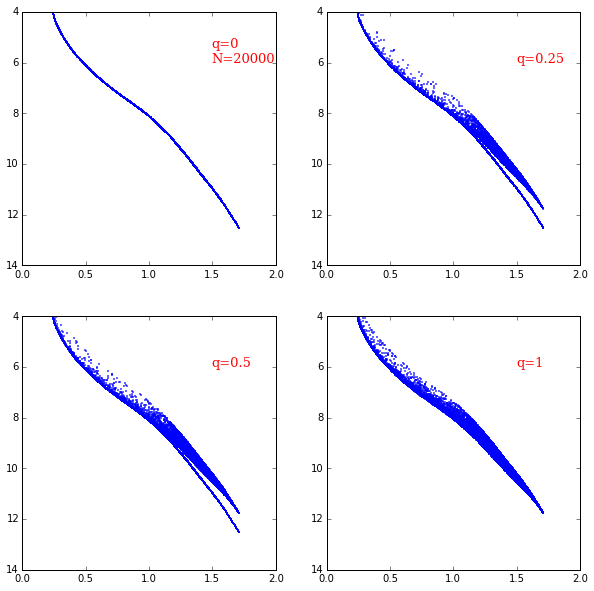

In [13]:
mpl.rcParams['figure.figsize'] = (10.0, 10.0)
fontdict={'size': 13, 'family': "serif", 'color': "red"}
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.scatter(cmd1['color'],cmd1['mag2'],marker='o', s=0.5, color='blue')
ax2 = fig.add_subplot(222)
ax2.scatter(cmd2['color'],cmd2['mag2'],marker='o', s=0.5, color='blue')
ax3 = fig.add_subplot(223)
ax3.scatter(cmd3['color'],cmd3['mag2'],marker='o', s=0.5, color='blue')
ax4 = fig.add_subplot(224)
ax4.scatter(cmd4['color'],cmd4['mag2'],marker='o', s=0.5, color='blue')
ax1.text(1.5,6,"q=0\nN="+str(nrequired),fontdict=fontdict)
ax2.text(1.5,6,"q=0.25",fontdict=fontdict)
ax3.text(1.5,6,"q=0.5",fontdict=fontdict)
ax4.text(1.5,6,"q=1",fontdict=fontdict)
ax1.set_xlim([0,2])
ax2.set_xlim([0,2])
ax3.set_xlim([0,2])
ax4.set_xlim([0,2])
ax1.set_ylim([14,4])
ax2.set_ylim([14,4])
ax3.set_ylim([14,4])
ax4.set_ylim([14,4])

<b>Results:</b>
For $q=0$, the mock data follows a track with no width, as expected for a population of single stars.
For $q=0.5$, the binaries broaden the CMD. However, there are some differences between the four magnitudes closest to the MSTO, and those dimmer. For $4 < r < 8$, the majority of stars are still close to the no-binary ridge. For $r>8$, a large fraction of stars are in binaries, and this shifts the CMD. The single star CMD separates from the binary star population in the CMD because for low primary masses, the only secondaries available have $M_{min} < M_{sec} < M_{pri}$ and as M_{pri} -> M_{min}, this means that each binary is composed approximately of two stars of the same brightness. <em> This feature is particular to the algorithm used to generate binaries. If the primaries were allowed to be paired instead with brown dwarfs, this empty region would be filled in.</em>. For $q=1.0$, all stars are in binary systems, so the single star tail disappears. 

In [25]:
xmin = min(cmd1['mag2'])
xmax = max(cmd1['mag2'])
dx = 0.2
nbins = int((xmax-xmin) / dx)
dmod_cb = 5 * np.log10(44000.) - 5.

#what is mag F160W for M = 0.17 Msun at D = 44 kpc (distance to Coma)?
mass = myiso.data['mass']
w  = np.argmin(abs(myiso.data['mass']-0.17))
fr_limit = myiso.data[strmag2][w] + dmod_cb
print "sdss r | M = 0.17 Msun = {0}".format(myiso.data[strmag2][w] + dmod_cb)

ValueError: field named F160W not found

### Effect of Increasing Binary Fraction on Luminosity Functions 

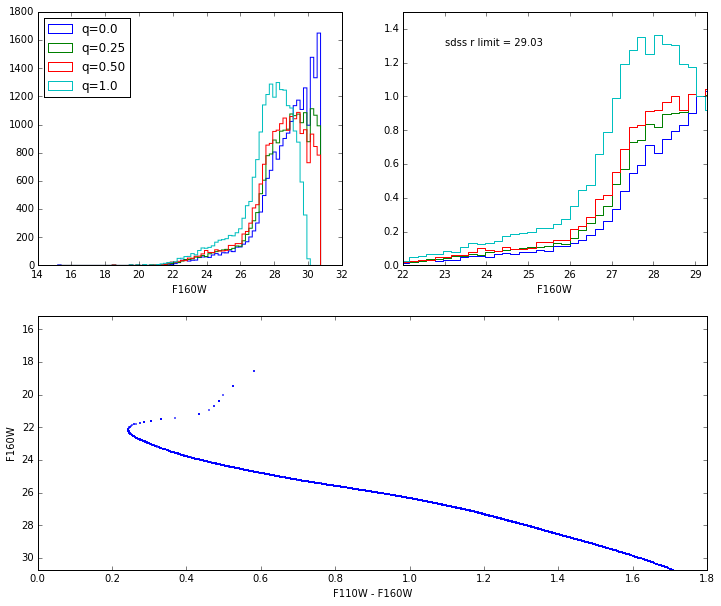

In [26]:

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2,2)
mpl.rcParams['figure.figsize'] = (12.0, 10.0)
fig = plt.figure()
ax1 = fig.add_subplot(gs[0,0])
(hist1, bins1, patches1) = ax1.hist(cmd1['mag2']+dmod_cb,histtype='step',bins=nbins, normed=False, align='mid',label="q=0.0");
(hist2, bins2, patches2) = ax1.hist(cmd2['mag2']+dmod_cb,histtype='step',bins=bins1, normed=False, align='mid',label="q=0.25");
(hist3, bins3, patches3) = ax1.hist(cmd3['mag2']+dmod_cb,histtype='step',bins=bins1, normed=False, align='mid',label="q=0.50");
(hist4, bins4, patches4) = ax1.hist(cmd4['mag2']+dmod_cb,histtype='step',bins=bins1, normed=False, align='mid',label="q=1.0");
ax1.set_xlabel(strmag2)
#ax1.set_ylim([0,.5])
ax1.legend(loc=2)
#scale to number at f160w_lim
w = np.argmin(abs(bins1 - fr_limit))
hist1n = hist1 / hist1[w]
hist2n = hist2 / hist2[w]
hist3n = hist3 / hist3[w]
hist4n = hist4 / hist4[w]
ax2 = fig.add_subplot(gs[0,1])
ax2.plot(0.5*(bins1[:-1]+bins1[1:]),hist1n,ls='steps')
ax2.plot(0.5*(bins1[:-1]+bins1[1:]),hist2n,ls='steps')
ax2.plot(0.5*(bins1[:-1]+bins1[1:]),hist3n,ls='steps')
ax2.plot(0.5*(bins1[:-1]+bins1[1:]),hist4n,ls='steps')
ax2.text(23,1.3,"sdss r limit = {0:<5.2f}".format(fr_limit))
ax2.set_xlabel(strmag2)
ax2.set_xlim([22,fr_limit+0.25])
ax2.set_ylim([0,1.5])
ax3 = fig.add_subplot(gs[1,:])
ax3.scatter(cmd1['color'],cmd1['mag2']+dmod_cb,marker='o', s=0.5, color='blue')
ax3.set_ylim([max(cmd1['mag2']+dmod_cb), min(cmd1['mag2']+dmod_cb)])
ax3.set_ylabel(strmag2)
ax3.set_xlabel(strmag1+' - '+strmag2)

<p><strong>Results:</strong> Top left panel - raw histograms of number of unresolved "stars" as function of Sloan r magnitude. Top-right panel. Counts normalized to number count at SDSS magnitude limit corresponding to mass limit in proposal (M = 0.17 Msun). </p>
<p>Bottom panel: For reference, CMD of $q=0.0$ isochrone.</p>

##Example 2: 

####Generating a synthetic CMD with Salpeter IMF, WFC3 F110W and F160W bands, and binary fraction <em>q=[0.0,0.5,1.0]</em>

In [19]:
myisoir = DartmouthIsochrone(-2.0,0.4,14.0,'wfc3')
myisoir.interpolate(dm=0.001,diagnose=False)
myisoir.has_interp()

#what is mag F160W for M = 0.17 Msun at D = 44 kpc (distance to Coma)?
mass = myisoir.data['mass']
w  = np.argmin(abs(myisoir.data['mass']-0.17))
f160w_limit = myisoir.data[strmag2][w] + dmod_cb
print "F160W | M = 0.17 Msun = {0}".format(myisoir.data[strmag2][w] + dmod_cb)


Proceed to interpolate based on mass...
Interpolated data located as self.data
Non-interpolated data located as self.iso
F160W | M = 0.17 Msun = 29.9692403493


In [21]:
strmag1 = 'F110W'
strmag2 = 'F160W'

isomass = myisoir.data['mass']

alpha = 2.35
fs = f_salpeter(isomass,alpha)
fk = f_kroupa(isomass,1.35,1.7,alpha_3=2.30)
Phi_s = np.cumsum(fs)
Phi_s = Phi_s / max(Phi_s)
Phi_k = np.cumsum(fk)
Phi_k = Phi_k / max(Phi_k)

#use salpeter
f_Phiinv = interpolate.splrep(Phi_s,isomass)

#Set binary fraction = number of binary systems
q = 1.0
nrequired = 20000

strmag1 = 'F110W'
strmag2 = 'F160W'

mass_min = 0.3
mass_max = 0.8
w = np.argmin(abs(isomass - mass_min))
mag_max = myisoir.data[strmag2][w]
w = np.argmin(abs(isomass - mass_max))
mag_min = myisoir.data[strmag2][w]
cmd1ir = SyntheticCMD(myisoir,strmag1,strmag2,mag_min,mag_max,nrequired,
    f_Phiinv,q=0.00).as_dict()
cmd2ir = SyntheticCMD(myisoir,strmag1,strmag2,mag_min,mag_max,nrequired,
    f_Phiinv,q=0.25).as_dict()
cmd3ir = SyntheticCMD(myisoir,strmag1,strmag2,mag_min,mag_max,nrequired,
    f_Phiinv,q=0.50).as_dict()
cmd4ir = SyntheticCMD(myisoir,strmag1,strmag2,mag_min,mag_max,nrequired,
    f_Phiinv,q=1.00).as_dict()

In [22]:
xmin = min(cmd1ir['mag2'])
xmax = max(cmd1ir['mag2'])
dx = 0.2
nbins = int((xmax-xmin) / dx)
dmod_cb = 5 * np.log10(44000.) - 5.

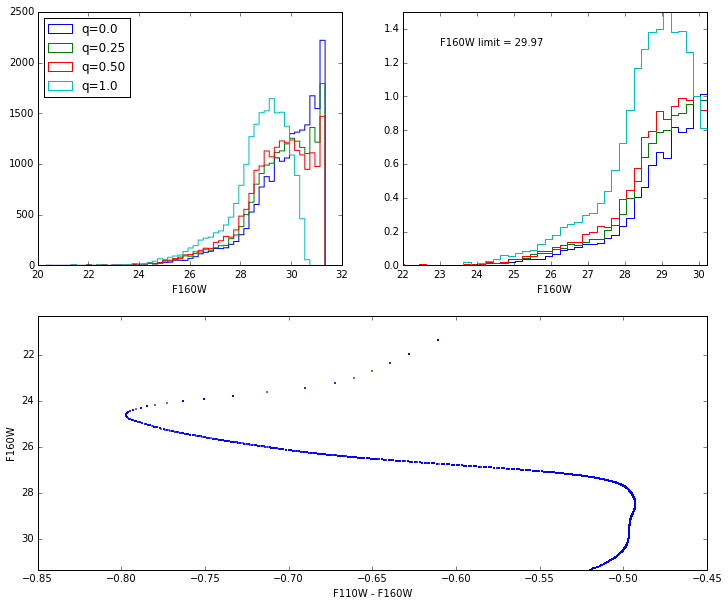

In [23]:
strmag1 = 'F110W'
strmag2 = 'F160W'
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2,2)
mpl.rcParams['figure.figsize'] = (12.0, 10.0)
fig = plt.figure()
ax1 = fig.add_subplot(gs[0,0])
(hist1, bins1, patches1) = ax1.hist(cmd1ir['mag2']+dmod_cb,histtype='step',bins=nbins, normed=False, align='mid',label="q=0.0");
(hist2, bins2, patches2) = ax1.hist(cmd2ir['mag2']+dmod_cb,histtype='step',bins=bins1, normed=False, align='mid',label="q=0.25");
(hist3, bins3, patches3) = ax1.hist(cmd3ir['mag2']+dmod_cb,histtype='step',bins=bins1, normed=False, align='mid',label="q=0.50");
(hist4, bins4, patches4) = ax1.hist(cmd4ir['mag2']+dmod_cb,histtype='step',bins=bins1, normed=False, align='mid',label="q=1.0");
ax1.set_xlabel(strmag2)
#ax1.set_ylim([0,.5])
ax1.legend(loc=2)
#scale to number at f160w_lim
w = np.argmin(abs(bins1 - f160w_limit))
hist1n = hist1 / hist1[w]
hist2n = hist2 / hist2[w]
hist3n = hist3 / hist3[w]
hist4n = hist4 / hist4[w]
ax2 = fig.add_subplot(gs[0,1])
ax2.plot(0.5*(bins1[:-1]+bins1[1:]),hist1n,ls='steps')
ax2.plot(0.5*(bins1[:-1]+bins1[1:]),hist2n,ls='steps')
ax2.plot(0.5*(bins1[:-1]+bins1[1:]),hist3n,ls='steps')
ax2.plot(0.5*(bins1[:-1]+bins1[1:]),hist4n,ls='steps')
ax2.text(23,1.3,"F160W limit = {0:<5.2f}".format(f160w_limit))
ax2.set_xlim([22,f160w_limit+0.25])
ax2.set_xlabel(strmag2)
ax2.set_xlim([22,f160w_limit+0.25])
ax2.set_ylim([0,1.5])
ax3 = fig.add_subplot(gs[1,:])
ax3.scatter(cmd1ir['color'],cmd1ir['mag2']+dmod_cb,marker='o', s=0.5, color='blue')
ax3.set_ylim([max(cmd1ir['mag2']+dmod_cb), min(cmd1ir['mag2']+dmod_cb)])
ax3.set_ylabel(strmag2)
ax3.set_xlabel(strmag1 + ' - ' + strmag2)